NCP-VAE: Variational Autoencoders with Noise Contrastive Priors

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
from datetime import datetime
from scipy.stats import pearsonr




def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

/mnt/c/Users/Maxwell Bruce/Desktop/honours/CurrentModels/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class NoiseContrastivePrior(nn.Module):
    def __init__(self, num_latent, noise_factor=0.1):
        super(NoiseContrastivePrior, self).__init__()
        self.noise_factor = noise_factor
        self.noise = nn.Parameter(torch.randn(num_latent), requires_grad=False)
        self.classifier = nn.Sequential(
            nn.Linear(num_latent, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, latent):
        noise_samples = self.noise_factor * torch.randn_like(latent)
        reweighting_factor = self.classifier(latent)
        return noise_samples, reweighting_factor

    def contrastive_loss(self, latent, noise_samples):
        latent_norm = F.normalize(latent, dim=-1)
        noise_norm = F.normalize(noise_samples, dim=-1)
        positive_score = torch.sum(latent_norm * latent_norm, dim=-1)
        negative_score = torch.sum(latent_norm * noise_norm, dim=-1)
        return -torch.mean(positive_score - negative_score)
    
    def reweighted_prior(self, latent, reweighting_factor):
        return reweighting_factor * latent
    
class FeatureExtractor(nn.Module):
    def __init__(self, num_latent, hidden_size, num_layers=1):
        super(FeatureExtractor, self).__init__()
        self.num_latent = num_latent
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.normalize = nn.LayerNorm(num_latent)
        self.linear = nn.Linear(num_latent, num_latent)
        self.leakyrelu = nn.LeakyReLU()
        self.gru = nn.GRU(num_latent, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        x = self.normalize(x)
        out = self.linear(x)
        out = self.leakyrelu(out)
        stock_latent, _ = self.gru(out)
        return stock_latent[:,-1,:] 

class FactorEncoder(nn.Module):
    def __init__(self, num_factors, num_portfolio, hidden_size):
        super(FactorEncoder, self).__init__()
        self.num_factors = num_factors
        self.linear = nn.Linear(hidden_size, num_portfolio)
        self.softmax = nn.Softmax(dim=0) 
        
        self.linear_mu = nn.Linear(num_portfolio, num_factors)
        self.linear_sigma = nn.Linear(num_portfolio, num_factors)
        self.softplus = nn.Softplus()
        
    def mapping_layer(self, portfolio_return):

        mean = self.linear_mu(portfolio_return.squeeze(1))
        sigma = self.softplus(self.linear_sigma(portfolio_return.squeeze(1)))
        return mean, sigma
    
    def forward(self, stock_latent, returns):
        weights = self.linear(stock_latent)
        weights = self.softmax(weights) 

        if returns.dim() == 1:
            returns = returns.unsqueeze(1)
        portfolio_return = torch.mm(weights.transpose(1,0), returns)
        
        return self.mapping_layer(portfolio_return)

class AlphaLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AlphaLayer, self).__init__()
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.leakyrelu = nn.LeakyReLU()
        self.mu_layer = nn.Linear(hidden_size, 1)
        self.sigma_layer = nn.Linear(hidden_size, 1)
        self.softplus = nn.Softplus()
        
    def forward(self, stock_latent):
        stock_latent = self.linear1(stock_latent)
        stock_latent = self.leakyrelu(stock_latent)
        alpha_mu = self.mu_layer(stock_latent)
        alpha_sigma = self.sigma_layer(stock_latent)
        return alpha_mu, self.softplus(alpha_sigma)
        
class BetaLayer(nn.Module):
    """calcuate factor exposure beta(N*K)"""
    def __init__(self, hidden_size, num_factors):
        super(BetaLayer, self).__init__()
        self.linear1 = nn.Linear(hidden_size, num_factors)
    
    def forward(self, stock_latent):
        beta = self.linear1(stock_latent)
        return beta
        
class FactorDecoder(nn.Module):
    def __init__(self, alpha_layer, beta_layer):
        super(FactorDecoder, self).__init__()

        self.alpha_layer = alpha_layer
        self.beta_layer = beta_layer
    
    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + eps * sigma
    
    def forward(self, stock_latent, factor_mu, factor_sigma):
        alpha_mu, alpha_sigma = self.alpha_layer(stock_latent)
        beta = self.beta_layer(stock_latent)

        factor_mu = factor_mu.view(-1, 1)
        factor_sigma = factor_sigma.view(-1, 1)
        factor_sigma[factor_sigma == 0] = 1e-6
        mu = alpha_mu + torch.matmul(beta, factor_mu)
        sigma = torch.sqrt(alpha_sigma**2 + torch.matmul(beta**2, factor_sigma**2) + 1e-6)

        return self.reparameterize(mu, sigma)

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        
        self.query = nn.Parameter(torch.randn(hidden_size))
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, stock_latent):
        self.key = self.key_layer(stock_latent)
        self.value = self.value_layer(stock_latent)
        attention_weights = torch.matmul(self.query, self.key.transpose(1,0))
        attention_weights = attention_weights / torch.sqrt(torch.tensor(self.key.shape[0])+ 1e-6)
        attention_weights = self.dropout(attention_weights)
        attention_weights = F.relu(attention_weights) 
        attention_weights = F.softmax(attention_weights, dim=0) 
        
        if torch.isnan(attention_weights).any() or torch.isinf(attention_weights).any():
            return torch.zeros_like(self.value[0])
        else:
            context_vector = torch.matmul(attention_weights, self.value) 
            return context_vector 

class FactorPredictor(nn.Module):
    def __init__(self, batch_size, hidden_size, num_factor):
        super(FactorPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_factor = num_factor
        self.attention_layers = nn.ModuleList([AttentionLayer(self.hidden_size) for _ in range(num_factor)])
        
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.leakyrelu = nn.LeakyReLU()
        self.mu_layer = nn.Linear(hidden_size, 1)
        self.sigma_layer = nn.Linear(hidden_size, 1)
        self.softplus = nn.Softplus()

    def forward(self, stock_latent):
        
        for i in range(self.num_factor):
            attention_layer = self.attention_layers[i](stock_latent)
            if i == 0:
                h_multi = attention_layer
            else:
                h_multi = torch.cat((h_multi, attention_layer), dim=0)
        h_multi = h_multi.view(self.num_factor, -1)

        h_multi = self.linear(h_multi)
        h_multi = self.leakyrelu(h_multi)
        pred_mu = self.mu_layer(h_multi)
        pred_sigma = self.sigma_layer(h_multi)
        pred_sigma = self.softplus(pred_sigma)
        pred_mu = pred_mu.view(-1)
        pred_sigma = pred_sigma.view(-1)
        return pred_mu, pred_sigma
    
class FactorVAE(nn.Module):
    def __init__(self, feature_extractor, factor_encoder, factor_decoder, factor_predictor):
        super(FactorVAE, self).__init__()
        self.feature_extractor = feature_extractor
        self.factor_encoder = factor_encoder
        self.factor_decoder = factor_decoder
        self.factor_predictor = factor_predictor

    @staticmethod
    def KL_Divergence(mu1, sigma1, mu2, sigma2):
        kl_div = (torch.log(sigma2/ sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5).sum()
        return kl_div

    def forward(self, x, returns):

        stock_latent = self.feature_extractor(x)
        factor_mu, factor_sigma = self.factor_encoder(stock_latent, returns)
        reconstruction = self.factor_decoder(stock_latent, factor_mu, factor_sigma)
        pred_mu, pred_sigma = self.factor_predictor(stock_latent)

        stock_adj = 0
        for i in range(len(returns)-1,-1,-1):
            if returns[i] == 0:
                stock_adj += 1
            else:
                break

        if stock_adj > 0:
            reconstruction_loss = F.mse_loss(reconstruction[:-stock_adj], returns[:-stock_adj])
        else:
            reconstruction_loss = F.mse_loss(reconstruction, returns)
            
        if torch.any(pred_sigma == 0):
            pred_sigma[pred_sigma == 0] = 1e-6
        kl_divergence = self.KL_Divergence(factor_mu, factor_sigma, pred_mu, pred_sigma)

        vae_loss = reconstruction_loss + kl_divergence
        return vae_loss, reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma 

    def prediction(self, x):
        stock_latent = self.feature_extractor(x)
        pred_mu, pred_sigma = self.factor_predictor(stock_latent)
        y_pred = self.factor_decoder(stock_latent, pred_mu, pred_sigma)

        return y_pred
    
class FactorVAEWithNCP(FactorVAE):
    def __init__(self, feature_extractor, factor_encoder, factor_decoder, factor_predictor, num_latent):
        super(FactorVAEWithNCP, self).__init__(feature_extractor, factor_encoder, factor_decoder, factor_predictor)
        self.ncp = NoiseContrastivePrior(num_latent)

    def forward(self, x, returns):
        stock_latent = self.feature_extractor(x)
        factor_mu, factor_sigma = self.factor_encoder(stock_latent, returns)
        reconstruction = self.factor_decoder(stock_latent, factor_mu, factor_sigma)
        pred_mu, pred_sigma = self.factor_predictor(stock_latent)

        noise_samples, reweighting_factor = self.ncp(stock_latent)
        ncp_loss = self.ncp.contrastive_loss(stock_latent, noise_samples)
        reweighted_prior = self.ncp.reweighted_prior(stock_latent, reweighting_factor)

        stock_adj = 0
        for i in range(len(returns)-1, -1, -1):
            if returns[i] == 0:
                stock_adj += 1
            else:
                break

        if stock_adj > 0:
            reconstruction_loss = F.mse_loss(reconstruction[:-stock_adj], returns[:-stock_adj])
        else:
            reconstruction_loss = F.mse_loss(reconstruction, returns)
            
        if torch.any(pred_sigma == 0):
            pred_sigma[pred_sigma == 0] = 1e-6
        kl_divergence = self.KL_Divergence(factor_mu, factor_sigma, pred_mu, pred_sigma)

        vae_loss = reconstruction_loss + kl_divergence + ncp_loss
        return vae_loss, reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma

    def prediction(self, x):
        stock_latent = self.feature_extractor(x)
        pred_mu, pred_sigma = self.factor_predictor(stock_latent)
        y_pred = self.factor_decoder(stock_latent, pred_mu, pred_sigma)
        return y_pred


In [3]:
def train(factor_model, dataloader, optimizer, seq_len):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    factor_model.to(device)
    factor_model.train()
    total_loss = 0
    with tqdm(total=len(dataloader), desc="Training") as pbar:
        for char, returns in dataloader: 
            if char.shape[1] != seq_len:
                continue
            inputs = char.to(device)
            labels = returns[:,-1].reshape(-1,1).to(device)
            inputs = inputs.float()
            labels = labels.float()
            
            optimizer.zero_grad()
            loss, reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma = factor_model(inputs, labels)
            total_loss += loss.item() * inputs.size(0)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'loss': loss.item()})
            pbar.update(1)
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss


In [4]:
@torch.no_grad()
def validate(factor_model, dataloader, seq_len):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    factor_model.to(device)
    factor_model.eval()
    total_loss = 0
    with tqdm(total=len(dataloader), desc="Validation") as pbar:
        for char, returns in dataloader:
            if char.shape[1] != seq_len:
                continue
            inputs = char.to(device)
            labels = returns[:,-1].reshape(-1,1).to(device)
            inputs = inputs.float()
            labels = labels.float()
            
            loss, reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma = factor_model(inputs, labels)
            total_loss += loss.item() * inputs.size(0)
            pbar.update(1)
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss


In [5]:
class StockDataset(Dataset):
    def __init__(self,features, returns):
        print(f"{features.shape} : {returns.shape}")
        self.features = features
        self.returns = returns
    def __len__(self):
        return len(self.returns)
    def __getitem__(self,idx):
        return self.features[idx],self.returns[idx]

In [6]:
num_latent = 19
batch_size = 300
seq_len = 20
num_factor = 8
hidden_size = 20
epochs = 35 ## 35
path = 'bestModelNCP2.pt'
pickle_path = 'processed_data/stock_data.pkl'
lr = 0.0003

In [7]:

class GlobalMinMaxScaler:
    def __init__(self):
        self.feature_scaler = None
        self.return_scaler = None

    def fit(self, features_datasets, returns_datasets):
        combined_features = np.concatenate(features_datasets, axis=0)
        self.feature_scaler = MinMaxScaler()
        self.feature_scaler.fit(combined_features.reshape(-1, combined_features.shape[-1]))

        combined_returns = np.concatenate(returns_datasets, axis=0)
        self.return_scaler = MinMaxScaler()
        self.return_scaler.fit(combined_returns.reshape(-1, 1))  

    def transform_features(self, data):
        return self.feature_scaler.transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

    def transform_returns(self, data):
        return self.return_scaler.transform(data.reshape(-1, 1)).reshape(data.shape)

    def inverse_transform_features(self, data):
        return self.feature_scaler.inverse_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

    def inverse_transform_returns(self, data):
        return self.return_scaler.inverse_transform(data.reshape(-1, 1)).reshape(data.shape)

with open(pickle_path, 'rb') as f:
    data = pickle.load(f)

train_features = data['train_features'].numpy()
val_features = data['val_features'].numpy()
test_features = data['test_features'].numpy()

train_returns = data['train_prices'].numpy()
val_returns = data['val_prices'].numpy()
test_returns = data['test_prices'].numpy()

scaler = GlobalMinMaxScaler()

scaler.fit(
    features_datasets=[train_features, val_features, test_features],
    returns_datasets=[train_returns, val_returns, test_returns]
)

train_features_scaled = scaler.transform_features(train_features)
val_features_scaled = scaler.transform_features(val_features)
test_features_scaled = scaler.transform_features(test_features)

train_returns_scaled = scaler.transform_returns(train_returns)
val_returns_scaled = scaler.transform_returns(val_returns)
test_returns_scaled = scaler.transform_returns(test_returns)

train_features_scaled = torch.tensor(train_features_scaled, dtype=torch.float32)
val_features_scaled = torch.tensor(val_features_scaled, dtype=torch.float32)
test_features_scaled = torch.tensor(test_features_scaled, dtype=torch.float32)

train_returns_scaled = torch.tensor(train_returns_scaled, dtype=torch.float32)
val_returns_scaled = torch.tensor(val_returns_scaled, dtype=torch.float32)
test_returns_scaled = torch.tensor(test_returns_scaled, dtype=torch.float32)

train_ds = StockDataset(train_features_scaled, train_returns_scaled)
val_ds = StockDataset(val_features_scaled, val_returns_scaled)
test_ds = StockDataset(test_features_scaled, test_returns_scaled)
num_latent = data['num_latent']

train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(val_ds, shuffle=False, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, shuffle=False, batch_size=batch_size)

def unscale_features(features):
    return torch.tensor(scaler.inverse_transform_features(features.cpu().numpy()), dtype=torch.float32)

def unscale_returns(returns):
    return torch.tensor(scaler.inverse_transform_returns(returns.cpu().numpy()), dtype=torch.float32)

/mnt/c/Users/Maxwell Bruce/Desktop/honours/CurrentModels/myenv/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.

torch.Size([1080804, 20, 20]) : torch.Size([1080804, 1])
torch.Size([55216, 20, 20]) : torch.Size([55216, 1])
torch.Size([138849, 20, 20]) : torch.Size([138849, 1])


In [8]:
feature_extractor = FeatureExtractor(num_latent=num_latent, hidden_size=hidden_size)
factor_encoder = FactorEncoder(num_factors=num_factor, num_portfolio=num_latent, hidden_size=hidden_size)
alpha_layer = AlphaLayer(hidden_size)
beta_layer = BetaLayer(hidden_size, num_factor)
factor_decoder = FactorDecoder(alpha_layer, beta_layer)
factor_predictor = FactorPredictor(batch_size, hidden_size, num_factor)
# factorVAE = FactorVAE(feature_extractor, factor_encoder, factor_decoder, factor_predictor)
factorVAE = FactorVAEWithNCP(feature_extractor, factor_encoder, factor_decoder, factor_predictor, num_latent=num_latent)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"*************** Using {device} ***************")
    
factorVAE.to(device)
best_val_loss = 10000.0
optimizer = torch.optim.Adam(factorVAE.parameters(), lr=lr)        

*************** Using cpu ***************


In [9]:
training_epoch_loss = []
validation_epoch_loss = []


for epoch in range(epochs):
    train_loss = train(factorVAE, train_dataloader, optimizer, seq_len)
    val_loss = validate(factorVAE, valid_dataloader, seq_len)

    training_epoch_loss.append(train_loss)
    validation_epoch_loss.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}") 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(factorVAE, path)

Validation: 100%|██████████| 185/185 [00:02<00:00, 68.59it/s]


Epoch 1: Train Loss: -0.9864, Validation Loss: -0.9929


Validation: 100%|██████████| 185/185 [00:02<00:00, 69.51it/s]


Epoch 2: Train Loss: -0.9997, Validation Loss: -0.9991


Validation: 100%|██████████| 185/185 [00:02<00:00, 68.97it/s]


Epoch 3: Train Loss: -0.9999, Validation Loss: -1.0009


Validation: 100%|██████████| 185/185 [00:02<00:00, 70.21it/s]


Epoch 4: Train Loss: -1.0000, Validation Loss: -1.0010


Validation: 100%|██████████| 185/185 [00:08<00:00, 22.93it/s]


Epoch 5: Train Loss: -1.0002, Validation Loss: -0.9982


Validation: 100%|██████████| 185/185 [00:03<00:00, 61.00it/s]


Epoch 6: Train Loss: -1.0001, Validation Loss: -1.0004


Validation: 100%|██████████| 185/185 [00:02<00:00, 64.30it/s]


Epoch 7: Train Loss: -1.0001, Validation Loss: -1.0010


Validation: 100%|██████████| 185/185 [00:02<00:00, 63.23it/s]


Epoch 8: Train Loss: -1.0005, Validation Loss: -0.9997


Validation: 100%|██████████| 185/185 [00:02<00:00, 62.81it/s]


Epoch 9: Train Loss: -0.9997, Validation Loss: -1.0016


Validation: 100%|██████████| 185/185 [00:02<00:00, 69.49it/s]


Epoch 10: Train Loss: -1.0000, Validation Loss: -0.9984


Validation: 100%|██████████| 185/185 [00:02<00:00, 62.97it/s]


Epoch 11: Train Loss: -1.0003, Validation Loss: -0.9995


Validation: 100%|██████████| 185/185 [00:02<00:00, 69.36it/s]


Epoch 12: Train Loss: -0.9999, Validation Loss: -0.9992


Validation: 100%|██████████| 185/185 [00:02<00:00, 68.46it/s]


Epoch 13: Train Loss: -0.9999, Validation Loss: -1.0000


Validation: 100%|██████████| 185/185 [00:02<00:00, 72.26it/s]


Epoch 14: Train Loss: -0.9996, Validation Loss: -1.0007


Validation: 100%|██████████| 185/185 [00:02<00:00, 64.79it/s]


Epoch 15: Train Loss: -0.9997, Validation Loss: -1.0005


Validation: 100%|██████████| 185/185 [00:02<00:00, 67.27it/s]


Epoch 16: Train Loss: -1.0002, Validation Loss: -0.9984


Validation: 100%|██████████| 185/185 [00:03<00:00, 60.61it/s]


Epoch 17: Train Loss: -1.0001, Validation Loss: -0.9991


Validation: 100%|██████████| 185/185 [00:02<00:00, 62.70it/s]


Epoch 18: Train Loss: -1.0002, Validation Loss: -0.9985


Validation: 100%|██████████| 185/185 [00:03<00:00, 58.20it/s]


Epoch 19: Train Loss: -1.0007, Validation Loss: -1.0007


Validation: 100%|██████████| 185/185 [00:02<00:00, 61.98it/s]


Epoch 20: Train Loss: -0.9999, Validation Loss: -0.9995


Validation: 100%|██████████| 185/185 [00:03<00:00, 61.19it/s]


Epoch 21: Train Loss: -1.0000, Validation Loss: -1.0004


Validation: 100%|██████████| 185/185 [00:02<00:00, 66.31it/s]


Epoch 22: Train Loss: -1.0002, Validation Loss: -1.0010


Validation: 100%|██████████| 185/185 [00:02<00:00, 70.11it/s]


Epoch 23: Train Loss: -1.0003, Validation Loss: -0.9989


Validation: 100%|██████████| 185/185 [00:02<00:00, 68.72it/s]


Epoch 24: Train Loss: -1.0004, Validation Loss: -0.9998


Validation: 100%|██████████| 185/185 [00:02<00:00, 66.87it/s]


Epoch 25: Train Loss: -0.9997, Validation Loss: -1.0001


Validation: 100%|██████████| 185/185 [00:02<00:00, 62.51it/s]


Epoch 26: Train Loss: -1.0003, Validation Loss: -0.9997


Validation: 100%|██████████| 185/185 [00:03<00:00, 59.93it/s]


Epoch 27: Train Loss: -1.0002, Validation Loss: -1.0003


Validation: 100%|██████████| 185/185 [00:04<00:00, 39.58it/s]


Epoch 28: Train Loss: -1.0003, Validation Loss: -1.0005


Validation: 100%|██████████| 185/185 [00:03<00:00, 55.60it/s]


Epoch 29: Train Loss: -1.0000, Validation Loss: -1.0008


Validation: 100%|██████████| 185/185 [00:03<00:00, 61.19it/s]


Epoch 30: Train Loss: -0.9999, Validation Loss: -0.9994


Validation: 100%|██████████| 185/185 [00:03<00:00, 57.53it/s]


Epoch 31: Train Loss: -1.0000, Validation Loss: -1.0007


Validation: 100%|██████████| 185/185 [00:03<00:00, 52.05it/s]


Epoch 32: Train Loss: -1.0000, Validation Loss: -0.9997


Validation: 100%|██████████| 185/185 [00:03<00:00, 56.71it/s]


Epoch 33: Train Loss: -1.0001, Validation Loss: -0.9983


Validation: 100%|██████████| 185/185 [00:02<00:00, 62.45it/s]


Epoch 34: Train Loss: -0.9999, Validation Loss: -1.0015


Validation: 100%|██████████| 185/185 [00:02<00:00, 64.24it/s]

Epoch 35: Train Loss: -0.9994, Validation Loss: -0.9988


<function matplotlib.pyplot.show(close=None, block=None)>

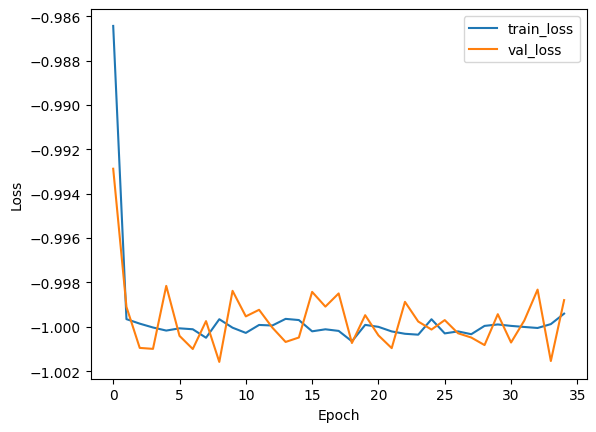

In [10]:
plt.plot(training_epoch_loss, label='train_loss')
plt.plot(validation_epoch_loss, label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show

In [11]:
class TestStockDataset(Dataset):
    def __init__(self, features, returns, dates, current_prices):
        self.features = features
        self.returns = returns
        self.dates = dates
        self.current_prices = current_prices

    def __len__(self):
        return len(self.returns)

    def __getitem__(self, idx):
        return self.features[idx], self.returns[idx], self.dates[idx], self.current_prices[idx]

factorVAE = torch.load(path)
factorVAE.to(device)

test_ds = TestStockDataset(test_features_scaled, test_returns_scaled, data['test_dates'].numpy(), data['test_current_prices'].numpy())
batch_size = 300
test_dataloader = DataLoader(test_ds, shuffle=False, batch_size=batch_size)


/tmp/ipykernel_28717/3991917126.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  factorVAE = torch.load(path)


100%|██████████| 463/463 [00:10<00:00, 45.72it/s]
/mnt/c/Users/Maxwell Bruce/Desktop/honours/CurrentModels/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4893: RuntimeWarning: invalid value encountered in subtract
  xm = x - xmean
/mnt/c/Users/Maxwell Bruce/Desktop/honours/CurrentModels/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4893: RuntimeWarning: invalid value encountered in subtract
  xm = x - xmean
/mnt/c/Users/Maxwell Bruce/Desktop/honours/CurrentModels/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4893: RuntimeWarning: invalid value encountered in subtract
  xm = x - xmean
/mnt/c/Users/Maxwell Bruce/Desktop/honours/CurrentModels/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4893: RuntimeWarning: invalid value encountered in subtract
  xm = x - xmean
/mnt/c/Users/Maxwell Bruce/Desktop/honours/CurrentModels/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4893: RuntimeWarning: invalid value encountered in subtra

R2 : 0.9899538159370422
MSE : 821.302734375
Accumulated Difference : 1907681.25
Abs Accumulated Difference : 2512404.25
Mean Diff : 13.739251136779785
Mean Abs Diff : 18.094507217407227
Std Dev : 25.1502628326416
Information Coefficient : 0.9964895142066013
ICIR : 0.4132983992852903
RankIC : 0.31840900154055257
RankICIR : 1.5260584711700524


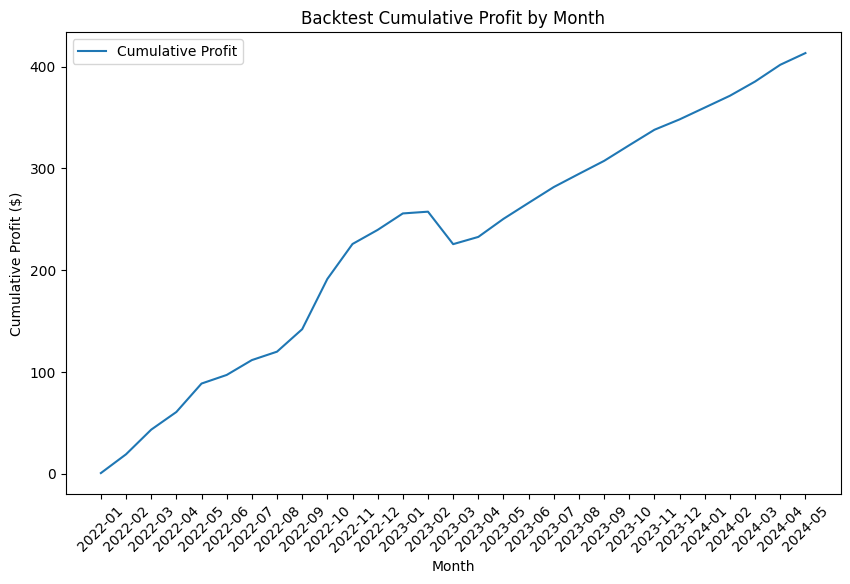

In [12]:
@torch.no_grad()
def backtest(factor_model, dataloader, seq_len):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    factor_model.to(device)
    factor_model.eval()

    daily_profits = []
    all_ic_values = []
    all_rank_ic_values = []
    all_predictions = []
    all_ground_truth = []
    acc_diff = 0.0
    abs_acc_diff = 0.0
    differences = []
    date_labels = []

    date_dict = {}

    with tqdm(total=len(dataloader)) as pbar:
        for char, returns, dates, current_prices in dataloader:
            if char.shape[1] != seq_len:
                continue

            char = char.float().to(device)
            returns = returns.float().to(device)
            current_prices = current_prices.float().to(device)
            predictions = factor_model.prediction(char)

            unscaled_predictions = unscale_returns(predictions).cpu().numpy()
            unscaled_returns = unscale_returns(returns).cpu().numpy()
            unscaled_current_prices = current_prices.cpu().numpy()
            dates = dates.cpu().numpy()

            dates = [datetime.utcfromtimestamp(int(ts)).strftime('%Y-%m-%d') for ts in dates.flatten()]

            for i, date in enumerate(dates):
                if date not in date_dict:
                    date_dict[date] = {'Predictions': [], 'Actuals': [], 'Current Prices': []}
                
                date_dict[date]['Predictions'].append(unscaled_predictions[i])
                date_dict[date]['Actuals'].append(unscaled_returns[i])
                date_dict[date]['Current Prices'].append(unscaled_current_prices[i])

            pbar.update(1)

    for date, values in date_dict.items():
        df = pd.DataFrame({
            'Prediction': np.array(values['Predictions']).flatten(),
            'Actual': np.array(values['Actuals']).flatten(),
            'Current Price': np.array(values['Current Prices']).flatten()
        })

        df['Predicted Change (%)'] = (df['Prediction'] - df['Current Price']) / df['Current Price']
        df['Actual Change (%)'] = (df['Actual'] - df['Current Price']) / df['Current Price']
        df['Change Ratio'] = df['Predicted Change (%)'] / df['Actual Change (%)']
        df = df.sort_values(by='Change Ratio', ascending=False)
        top_5 = df.head(5)

        daily_profit = 0
        for _, row in top_5.iterrows():
            investment = 100
            current_price = row['Current Price']
            actual_return = row['Actual']
            profit = investment * (actual_return - current_price) / current_price
            daily_profit += profit

        daily_profits.append(daily_profit)
        date_labels.append(date)

        rank_ic, _ = spearmanr(df['Change Ratio'], df['Actual Change (%)'])
        if not np.isnan(rank_ic):
            all_rank_ic_values.append(rank_ic)

        ic, _ = pearsonr(df['Change Ratio'], df['Actual Change (%)'])
        if not np.isnan(ic):
            all_ic_values.append(ic)

        differences.extend((df['Prediction'].values - df['Actual'].values).flatten())
        acc_diff += np.sum(df['Prediction'].values - df['Actual'].values)
        abs_acc_diff += np.sum(np.abs(df['Prediction'].values - df['Actual'].values))

    all_predictions = np.concatenate([np.array(values['Predictions']).flatten() for values in date_dict.values()])
    all_ground_truth = np.concatenate([np.array(values['Actuals']).flatten() for values in date_dict.values()])

    overall_ic = np.corrcoef(all_predictions, all_ground_truth)[0, 1]

    y_mean = np.mean(all_ground_truth)
    ss_tot = np.sum((all_ground_truth - y_mean) ** 2)
    ss_res = np.sum((all_ground_truth - all_predictions) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    mse = mean_squared_error(all_ground_truth, all_predictions)
    std_dev = np.std(differences)

    mean_ic = np.mean(all_ic_values) if all_ic_values else np.nan
    std_ic = np.std(all_ic_values) if all_ic_values else np.nan
    icir = mean_ic / std_ic if std_ic != 0 and not np.isnan(std_ic) else np.nan

    mean_rank_ic = np.mean(all_rank_ic_values) if all_rank_ic_values else np.nan
    std_rank_ic = np.std(all_rank_ic_values) if all_rank_ic_values else np.nan
    rank_icir = mean_rank_ic / std_rank_ic if std_rank_ic != 0 and not np.isnan(std_rank_ic) else np.nan

    profit_df = pd.DataFrame({'Date': date_labels, 'Profit': daily_profits})
    profit_df['Date'] = pd.to_datetime(profit_df['Date'], format='%Y-%m-%d')
    monthly_profits = profit_df.groupby(profit_df['Date'].dt.to_period('M')).agg({'Profit': 'sum'})

    print(f"R2 : {r2}")
    print(f"MSE : {mse}")
    print(f"Accumulated Difference : {acc_diff}")
    print(f"Abs Accumulated Difference : {abs_acc_diff}")
    print(f"Mean Diff : {acc_diff / len(all_predictions)}")
    print(f"Mean Abs Diff : {abs_acc_diff / len(all_predictions)}")
    print(f"Std Dev : {std_dev}")
    print(f"Information Coefficient : {overall_ic}")
    print(f"ICIR : {icir}")
    print(f"RankIC : {mean_rank_ic}")
    print(f"RankICIR : {rank_icir}")

    return monthly_profits, mean_rank_ic, rank_icir, r2, mse, acc_diff, abs_acc_diff, std_dev, overall_ic, icir


monthly_profits, mean_rank_ic, rank_icir, r2, mse, acc_diff, abs_acc_diff, std_dev, information_coefficient, icir = backtest(factorVAE, test_dataloader, seq_len)

plt.figure(figsize=(10, 6))
plt.plot(monthly_profits.index.astype(str), monthly_profits['Profit'].cumsum(), label='Cumulative Profit')
plt.xlabel('Month')
plt.ylabel('Cumulative Profit ($)')
plt.xticks(rotation=45)
plt.title('Backtest Cumulative Profit by Month')
plt.legend()
plt.show()


In [13]:
print(monthly_profits['Profit'].cumsum())

Date
2022-01      0.472019
2022-02     18.955105
2022-03     43.171894
2022-04     60.534050
2022-05     88.489052
2022-06     96.949577
2022-07    111.563408
2022-08    119.843498
2022-09    141.933960
2022-10    191.323975
2022-11    225.711609
2022-12    239.576782
2023-01    255.756119
2023-02    257.482452
2023-03    225.552231
2023-04    232.679214
2023-05    250.427170
2023-06    266.145264
2023-07    281.714355
2023-08    294.662811
2023-09    307.440033
2023-10    322.847778
2023-11    338.032745
2023-12    348.231995
2024-01    359.842651
2024-02    371.475250
2024-03    385.455811
2024-04    401.922363
2024-05    413.426239
Freq: M, Name: Profit, dtype: float32


In [14]:
from datetime import datetime

current_dateTime = datetime.now().astimezone()

print(current_dateTime)

2024-09-02 17:37:16.410959+09:30
